<a href="https://colab.research.google.com/github/YairYarden/Deep-Learning/blob/feature%2Fassignment1_LeNet5/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code based on Udacity course

# Imports

In [11]:
import torch
import numpy as np
from datetime import datetime 
import os

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, SubsetRandomSampler

import ssl

import matplotlib.pyplot as plt

# check if CUDA is available
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


CUDA is available!  Training on GPU ...


In [12]:
from google.colab import drive

drive.mount('/content/drive')

DIR_PATH = '/content/drive/MyDrive/Deep learning 05107255/Homework1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [13]:
ssl._create_default_https_context = ssl._create_unverified_context

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 30
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    ])

# choose the training and test datasets
train_data = datasets.FashionMNIST('data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST('data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Visualize a batch of training data



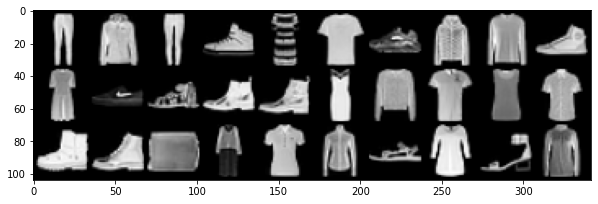

In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10,10))
grid = torchvision.utils.make_grid(tensor=images, nrow=10)
grid = np.clip(grid,0,1)
plt.imshow(X=np.transpose(grid, axes=(1,2,0)), cmap="gray");


# Define The Network

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class LeNet5(nn.Module):
    def conv_block(self, in_features, out_features, kernel_size, use_pooling=True, use_dropout=False, use_batchnorm=False, dropout=0.2):
      layers = [nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=kernel_size, stride=1)]
      if use_batchnorm:
        layers.append(nn.BatchNorm2d(out_features))
      layers.append(nn.Tanh())
      # layers.append(nn.ReLU())
      # if use_dropout:
      #   layers.append(nn.Dropout(dropout))
      if use_pooling:
        # layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(nn.AvgPool2d(kernel_size=2, stride=2))
      block = nn.Sequential(*layers)
      return block

    def fc_block(self, in_features, out_features, use_dropout=False, use_batchnorm=False, dropout=0.5):
      layers = [nn.Linear(in_features=in_features , out_features=out_features)]
      if use_batchnorm:
        layers.append(nn.BatchNorm1d(out_features))
      layers.append(nn.Tanh()) 
      # layers.append(nn.ReLU()) 
      if use_dropout:
        layers.append(nn.Dropout(dropout))
      block = nn.Sequential(*layers)
      return block

    def __init__(self, n_classes=10, use_dropout=False, use_batchnorm=False):
        super(LeNet5, self).__init__()
        # convolutional layer (sees 32x32x1 image tensor)
        self.conv_layer1 = self.conv_block(1, 6, 5, True, use_dropout, use_batchnorm)
        # convolutional layer (sees 28x28x6 tensor)
        self.conv_layer2 = self.conv_block(6, 16, 5, True, use_dropout, use_batchnorm)
        # convolutional layer (sees 10x10x16 tensor)
        self.conv_layer3 = self.conv_block(16, 120, 5, False, use_dropout, use_batchnorm)
        # Flatten 
        self.flatten = nn.Flatten(start_dim=1)
        # linear layer sees 120 -> 84
        self.fc1_layer = self.fc_block(120, 84, use_dropout, use_batchnorm)
        # linear layer (84 -> n_classes)
        self.fc2_layer = self.fc_block(84, n_classes, use_dropout, use_batchnorm)

        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)

        # flatten image input
        x = x.view(-1, 120)

        # add 1st hidden layer, with relu activation function
        x = self.fc1_layer(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2_layer(x)
        return x

# create a complete CNN
num_classes = 10
model = LeNet5(num_classes, use_dropout=True, use_batchnorm=True).to(DEVICE)
print(model)

LeNet5(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1_layer): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc2_laye

# Specify Loss function & Optimizer

In [16]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Functions For Training the network

In [17]:
def compute_model_accuracy(model, data_loader, is_gpu_available):
    
    correct_pred = 0 
    num_examples = 0
    
    with torch.no_grad():
        model.eval()
        for data, target in data_loader:
            if is_gpu_available:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            _, predicted_labels = torch.max(output, 1) 

            num_examples += target.size(0)
            correct_pred += (predicted_labels == target).sum()

    return correct_pred.float() / num_examples
    
# --------------------------------------------------------------------------------------------------
def train(train_loader, model, criterion, optimizer, is_gpu_available):
    running_loss = 0.0
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        running_loss += loss.item()*data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss
# --------------------------------------------------------------------------------------------------
def validate(test_loader, model, criterion, is_gpu_available):
    running_loss = 0.0

    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        running_loss += loss.item()*data.size(0)
    
    # calculate average losses
    valid_loss = running_loss/len(valid_loader.sampler)
               
    return model, valid_loss      
# --------------------------------------------------------------------------------------------------
def training_loop(model,
                  criterion,
                  optimizer,
                  train_loader,
                  test_loader,
                  epochs,
                  is_gpu_available,
                  log_dir: str = None,
                  train_type=None):
     
    # set objects for storing metrics
    train_losses = []
    test_losses = []
    train_acc_vec = []
    test_acc_vec = []

    print(f'{datetime.now().time().replace(microsecond=0)} START')

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, is_gpu_available)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, test_loss = validate(test_loader, model, criterion, is_gpu_available)
            test_losses.append(test_loss)

            train_acc = compute_model_accuracy(model, train_loader, is_gpu_available)
            train_acc_vec.append(train_acc.cpu())
            test_acc = compute_model_accuracy(model, test_loader, is_gpu_available)
            test_acc_vec.append(test_acc.cpu())    
      

        print(
          f'{datetime.now().time().replace(microsecond=0)} --- '
          f'Epoch: {epoch}\t'
          f'Train loss: {train_loss:.4f}\t'
          f'Test loss: {test_loss:.4f}\t'
          f'Train accuracy: {train_acc:.4f}\t'
          f'Test accuracy: {test_acc:.4f}'
        )

    # plot_train_and_valid_losses(train_losses, test_losses, train_type)
    # plot_train_and_valid_acc(train_acc_vec, test_acc_vec, train_type)

    return model, optimizer, (train_losses, test_losses), (train_acc_vec, test_acc_vec)

# --------------------------------------------------------------------------------------------------



# Plotting & Helper Functions

In [18]:
def plot_train_and_valid_losses(train_losses, test_losses, train_type=None):
  
    train_losses = np.array(train_losses) 
    test_losses = np.array(test_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(test_losses, color='red', label='Validation loss')
    title = "Loss over epochs"
    if train_type:
      title += "\n" + train_type
    ax.set(title=title, 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
# --------------------------------------------------------------------------------------------------
def plot_train_and_valid_acc(train_acc, valid_acc, train_type=None):

    train_acc = np.array(train_acc) 
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_acc, color='blue', label='Training Accuracy') 
    ax.plot(valid_acc, color='red', label='Validation Accuracy')
    title = "Accuracy over epochs"
    if train_type:
      title += "\n" + train_type
    ax.set(title=title, 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
# --------------------------------------------------------------------------------------------------
def save_model(model, optimizer, dir_path, train_type=None):
  # create checkpints folder
  checkpoint_folder = os.path.join(dir_path, 'checkpoints')
  os.makedirs(checkpoint_folder, exist_ok=True)
  # save model
  curr_datetime = datetime.now().strftime("%y_%m_%d_%H:%M:%S")
  model_name = f'{curr_datetime}'.replace(':', '_')
  if train_type:
    # model_name = train_type + '_' + model_name
    model_name = train_type
  ckpt_path = os.path.join(checkpoint_folder, f'{model_name}.ckpt')
  torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'use_dropout': model.use_dropout,
    'use_batchnorm': model.use_batchnorm,
    
  }, ckpt_path)

  print(f'model saved to "{ckpt_path}"')
# --------------------------------------------------------------------------------------------------

# Train the Network

Basic Model

In [19]:
num_epochs = 15
# basic network
model = LeNet5(num_classes, use_dropout=False, use_batchnorm=False).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01)

model, optimizer, (train_losses_basic, test_losses_basic), (train_acc_basic, test_acc_basic) = training_loop(model, criterion, optimizer,
                                                                                                            train_loader, test_loader, num_epochs,
                                                                                                            is_gpu_available,
                                                                                                            train_type='basic')
save_model(model, optimizer, DIR_PATH, train_type='basic')
# ----------------------------------------------------------------------------------
# using dropout
model = LeNet5(num_classes, use_dropout=True, use_batchnorm=False).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)
model, optimizer, (train_losses_dropout, test_losses_dropout), (train_acc_dropout, test_acc_dropout) = training_loop(model, criterion, optimizer,
                                                                                                                    train_loader, test_loader, num_epochs,
                                                                                                                    is_gpu_available,
                                                                                                                    train_type='dropout')
save_model(model, optimizer, DIR_PATH, train_type='dropout')
# # ----------------------------------------------------------------------------------
# # using weight decay
model = LeNet5(num_classes, use_dropout=False, use_batchnorm=False).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
model, optimizer, (train_losses_wd, test_losses_wd), (train_acc_wd, test_acc_wd) = training_loop(model, criterion, optimizer,
                                                                                                train_loader, test_loader, num_epochs,
                                                                                                is_gpu_available,
                                                                                                train_type='weight_decay')
save_model(model, optimizer, DIR_PATH, train_type='weight_decay')
# ----------------------------------------------------------------------------------
# using batch normalization
model = LeNet5(num_classes, use_dropout=False, use_batchnorm=True).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

model, optimizer, (train_losses_bn, test_losses_bn), (train_acc_bn, test_acc_bn) = training_loop(model, criterion, optimizer,
                                                                                                  train_loader, test_loader, num_epochs,
                                                                                                  is_gpu_available,
                                                                                                  train_type='batch_norm')
save_model(model, optimizer, DIR_PATH, train_type='batch_norm')

10:21:10 START
10:21:45 --- Epoch: 0	Train loss: 1.3988	Test loss: 1.4587	Train accuracy: 0.5370	Test accuracy: 0.5328
10:22:20 --- Epoch: 1	Train loss: 1.1013	Test loss: 1.3123	Train accuracy: 0.5799	Test accuracy: 0.5731
10:22:55 --- Epoch: 2	Train loss: 1.0235	Test loss: 1.2489	Train accuracy: 0.5950	Test accuracy: 0.5897
10:23:31 --- Epoch: 3	Train loss: 0.9807	Test loss: 1.2068	Train accuracy: 0.6217	Test accuracy: 0.6175
10:24:06 --- Epoch: 4	Train loss: 0.9540	Test loss: 1.1799	Train accuracy: 0.6402	Test accuracy: 0.6349
10:24:41 --- Epoch: 5	Train loss: 0.9356	Test loss: 1.1606	Train accuracy: 0.6479	Test accuracy: 0.6456
10:25:16 --- Epoch: 6	Train loss: 0.9210	Test loss: 1.1498	Train accuracy: 0.6703	Test accuracy: 0.6598
10:25:51 --- Epoch: 7	Train loss: 0.9102	Test loss: 1.1320	Train accuracy: 0.6651	Test accuracy: 0.6601
10:26:25 --- Epoch: 8	Train loss: 0.9012	Test loss: 1.1216	Train accuracy: 0.6765	Test accuracy: 0.6691
10:27:00 --- Epoch: 9	Train loss: 0.8938	Test los

# Plot all models together

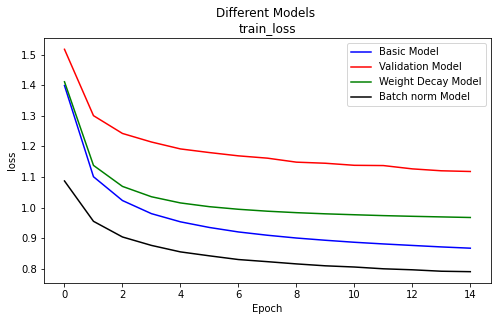

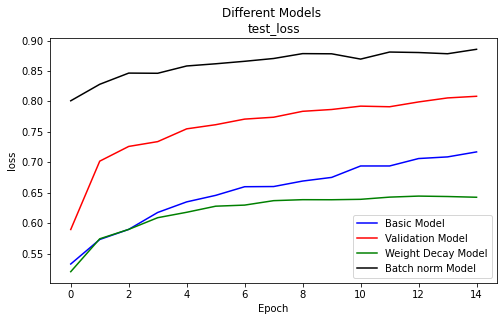

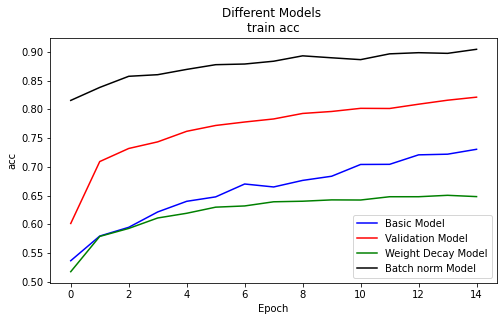

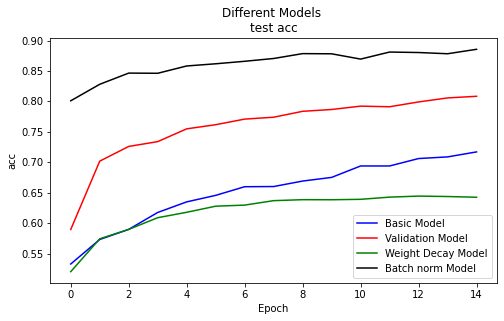

In [20]:
def plot_all_models(basic_vec, dropout_vec, weight_decay_vec, batch_norm_vec, plot_type = None):
  # Convert to numpy arrays
  basic_vec = np.array(basic_vec) 
  dropout_vec = np.array(dropout_vec) 
  weight_decay_vec = np.array(weight_decay_vec) 
  batch_norm_vec = np.array(batch_norm_vec) 

  fig, ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(basic_vec, color='blue', label='Basic Model') 
  ax.plot(dropout_vec, color='red', label='Validation Model')
  ax.plot(weight_decay_vec, color='green', label='Weight Decay Model')
  ax.plot(batch_norm_vec, color='black', label='Batch norm Model')

  title = "Different Models "
  if plot_type:
    title += "\n" + plot_type

  if('loss' in plot_type):
    ylabel_name = 'loss'
  else:
    ylabel_name = 'acc'

  ax.set(title=title, 
          xlabel='Epoch',
          ylabel=ylabel_name) 
  ax.legend()
  fig.show()

plot_all_models(train_losses_basic, train_losses_dropout, train_losses_wd, train_losses_bn, plot_type = 'train_loss')
plot_all_models(test_acc_basic, test_acc_dropout, test_acc_wd, test_acc_bn, plot_type = 'test_loss')
plot_all_models(train_acc_basic, train_acc_dropout, train_acc_wd, train_acc_bn, plot_type = 'train acc')
plot_all_models(test_acc_basic, test_acc_dropout, test_acc_wd, test_acc_bn, plot_type = 'test acc')

# Test Pre-trained Models

In [21]:
# #@title Load checkpoint and rebuild model
# model_name = "basic" #@param ["basic", "batch_norm", "dropout", "weight_decay"]

# # load checkpoint
# ckpt_path = f'{DIR_PATH}/checkpoints/{model_name}.ckpt'
# checkpoint = torch.load(ckpt_path)

# N_CLASSES = 10
# model = LeNet5(N_CLASSES,
#                use_dropout=checkpoint['use_dropout'],
#                use_batchnorm=checkpoint['use_batchnorm']
#               ).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters())

# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



In [22]:
# # run loaded model on test data
# model, test_loss = validate(test_loader, model, criterion, is_gpu_available)
# test_acc = compute_model_accuracy(model, test_loader, is_gpu_available)

# print(
#   f'Test accuracy: {test_acc:.4f}\t'
#   f'Test Loss: {test_loss:.4f}\t'
# )